In [1]:
from resources.notebook_library import *
from resources.gate_simulation.ghz import ghz_simulation
from resources.gate_simulation.ghz import gate_simulation_functions
from resources.dataframe_lib import conditionally_append_result
GateSimulation  = ghz_simulation
sim = GateSimulation.Simulation('O-x-O',load_setup=True,load_analytical=False)

Loading O-x-O setup
Preparing Analytical sub-class
Obtaining and saving expression for fidelity of GHZ-2


Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/history.py", line 576, in end_session
    self.db.execute("""UPDATE sessions SET end=?, num_cmds=? WHERE
sqlite3.OperationalError: disk I/O error


Preparing SuperoperatorBellPair sub-class

Done!


# Obtain grid(s) of performance

In [2]:
# Global Parameters 
kSweep = [0.95]   #[0.995]

CSweep =[12,13,14,15,16,17,18,19,20]#[25]#[25,50,75]#,50,75]

SplitSweep =[9,10]#[10]#[5,10,15]#,10,15,20]# [5,10]
 

# Bounds of optimization
## DE will be multiplied by  np.sqrt(C_val)/gamma_val
DE_min = 0.01 
DE_max = 20
tg_min = 0.7
tg_max = 1.2
rot_p_min = - np.pi/2 
rot_p_max = - rot_p_min
rot_i_min = - np.pi/2  
rot_i_max = -rot_i_min
rot_b_min = - np.pi/2 * 10**(-20)
rot_b_max = -rot_b_min

# Optimization settings
opt_settings_dict = {
"ghz_dim":2,                # 3-ghz state or 4-ghz state
'swap_into_memory':False,    # Use of nuclear memory  None corresponds to seeking for a maximum
'fidelity_cap': 0.999 , 'confidence_interval':0.99, #Cost function parameters
"n_cores": 16,  # Number of cores to use in optimization
"disp_bool" : True, "maxiter":None} # Show optimization progress

## Using analytical simulations

In [3]:
gamma_val = sim.parameters[sg.var('gamma')]

SplitSweep = [spl*gamma_val for spl in SplitSweep] # for gamma_val = 1 it is not necessary

AllParams = [(a,b,c) for a in kSweep for b in CSweep for c in SplitSweep] # Create a 3-d grid for hardware parameters

TotalParamElems = NumElemsInList(AllParams)


CurrentNumberOfSimulations = 1
Results = [ [{} for j in range(len(SplitSweep))] for i in range(len(CSweep))]
for  (k, C_val , max_split) in AllParams:
    print(f'Optimizing {CurrentNumberOfSimulations} out of {TotalParamElems}')
    CurrentNumberOfSimulations +=1
    c_val = k/ (4-4*k)
    
    hardware_dict = {'c': c_val,'k':k , 'C':C_val ,'max_split': max_split}

    sim.Analytical.obtain_gate_performance_hardware(hardware_dict)
    bounds = [[0 , max_split] , [0,DE_max*np.sqrt(C_val)/gamma_val ] , [tg_min,tg_max]  ]
    # Add rotation bounds depending on the ghz_dim
    #for i in range(opt_settings_dict["ghz_dim"]) : bounds.append([rot_min,rot_max]) 
    for i in range(opt_settings_dict["ghz_dim"]) : bounds.append([rot_p_min,rot_p_max]) 
    for i in range(opt_settings_dict["ghz_dim"]) : bounds.append([rot_i_min,rot_i_max]) 
    if opt_settings_dict["ghz_dim"] >2:
        bounds.append([rot_p_min,rot_p_max]) 
        bounds.append([rot_i_min,rot_i_max]) 
    
    sim.Analytical.optimize_gate_performance_hardware(bounds,opt_settings_dict)
    
    optimized_performance_dict = sim.Analytical.optimized_performance_dict
    opt_cost_function = gate_simulation_functions.gate_performance_cost_function(optimized_performance_dict,opt_settings_dict)

    tunable_params_dict = sim.Analytical.opt_tunable_dict
    
    result = {'hardware': hardware_dict , 
            'performance': optimized_performance_dict,
            'tuning': tunable_params_dict,
            'opt_settings' : opt_settings_dict, 
            'cost': opt_cost_function}
    i = np.where(C_val == np.array(CSweep) )[0][0]
    j = np.where(max_split == np.array(SplitSweep) )[0][0]
    Results[i][j] = result
    conditionally_append_result(result)
    gc.collect()  # clear unreferenced memory
    clear_output(wait=True)

Optimizing 18 out of 18
differential_evolution step 1: f(x)= 3.62071
differential_evolution step 2: f(x)= 3.62071
differential_evolution step 3: f(x)= 1.29577
differential_evolution step 4: f(x)= 0.846134
differential_evolution step 5: f(x)= 0.0994627
differential_evolution step 6: f(x)= 0.0148172
differential_evolution step 7: f(x)= 0.0148172
differential_evolution step 8: f(x)= 0.0148172
differential_evolution step 9: f(x)= 0.0148172
differential_evolution step 10: f(x)= 0.0148172
differential_evolution step 11: f(x)= 0.0148172
differential_evolution step 12: f(x)= -2.05239
differential_evolution step 13: f(x)= -2.2279
differential_evolution step 14: f(x)= -2.2279
differential_evolution step 15: f(x)= -4.50348
differential_evolution step 16: f(x)= -4.50348
differential_evolution step 17: f(x)= -4.99183
differential_evolution step 18: f(x)= -5.90421
differential_evolution step 19: f(x)= -7.28342
differential_evolution step 20: f(x)= -9.03706
differential_evolution step 21: f(x)= -9.03

# Plot result

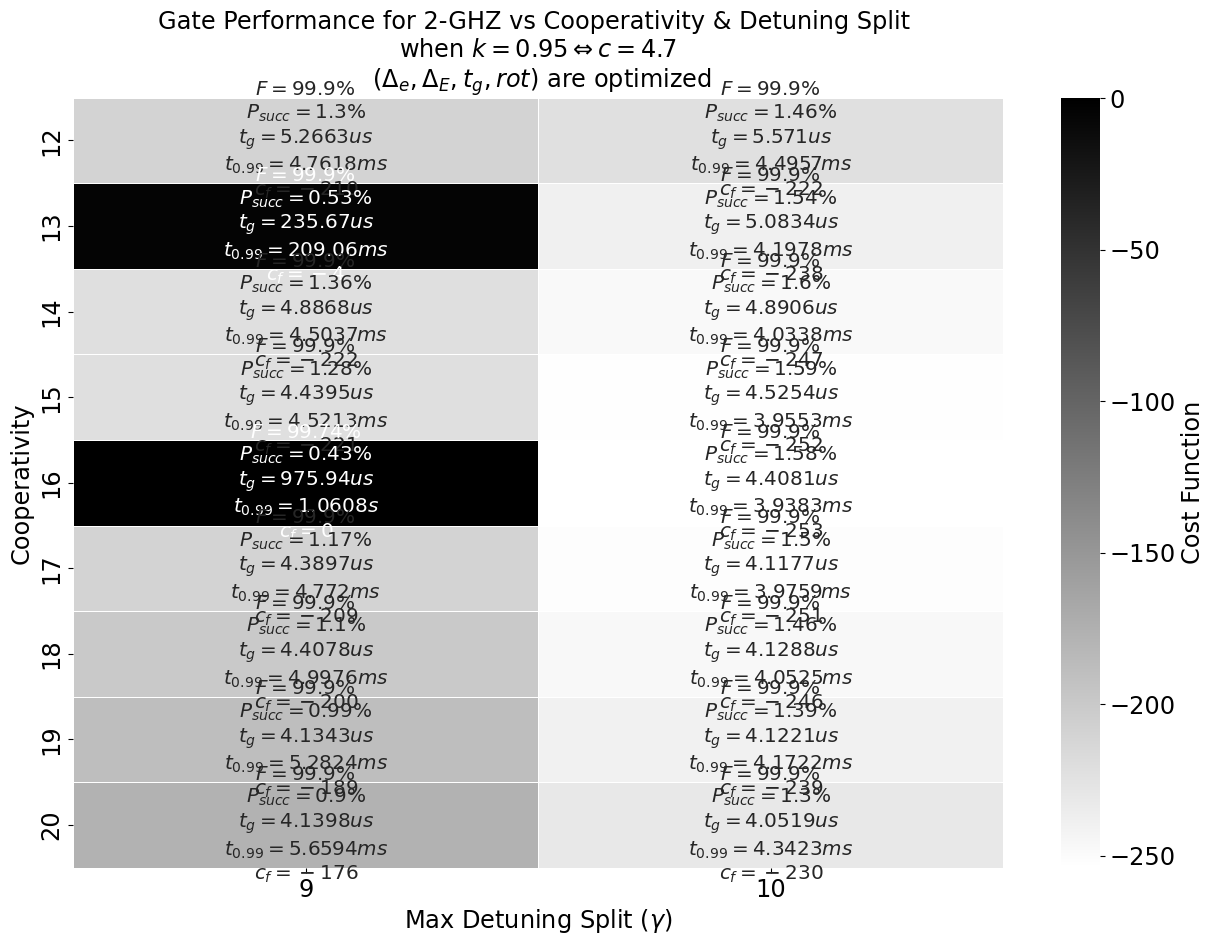

{'cost': -253.91416062932495,
 'hardware': {'C': 16, 'c': 4.749999999999996, 'k': 0.95, 'max_split': 10},
 'opt_settings': {'confidence_interval': 0.99,
                  'disp_bool': True,
                  'fidelity_cap': 0.999,
                  'ghz_dim': 2,
                  'maxiter': None,
                  'n_cores': 16,
                  'swap_into_memory': False},
 'performance': {'concurrence': 0.9961429886306893,
                 'fidelity': 0.999001075966036,
                 'gate_time': 132.24194862635724,
                 'p_success': 0.01576899820334455,
                 'swap_into_memory': False,
                 't_conf': 0.003938338836721454},
 'tuning': {De: 3.8370642601372977,
            DE: 7.422467679144134,
            tgr: 0.9467929900053619,
            r0_p: -1.1080436627593222,
            r0_i: -0.831004142098257,
            tgs: 132.24194862635724,
            rot: -2.5437236373094745,
            De0: -6.162935739862702}}


In [7]:
plot_results(Results,plot_big=True)
costs = np.array([[Results[i][j]['cost'] for j in range(len(SplitSweep))]for i in range(len(CSweep))])
res_min = Results[ArgMin(costs)[0]][ArgMin(costs)[1]]
pprint(res_min)


# Print results

In [8]:

for i,C in enumerate(CSweep):
    for j,spl in enumerate(SplitSweep):
        conditionally_append_result(Results[i][j])

        #print(Results[i][j]['tuning'][sg.var('DE')]/np.sqrt(C))
        #print(Results[i][j]['tuning'][sg.var('De')],spl)
        #print([Results[i][j]['tuning'][sg.var(f'r{k}_r')]  for k in range(opt_settings_dict["ghz_dim"] ) ])
       

# Superoperator

In [11]:
hardware_dict = res_min["hardware"]
CcDe0_dict = {sg.var('C'): hardware_dict['C'] , sg.var('c'): hardware_dict['c'] }
res_min["tuning"][sg.var('De0')] =  res_min["tuning"][sg.var('De')] - res_min["hardware"]["max_split"] 
res_min["tuning"][sg.var('r1_p')] =res_min["tuning"][sg.var('r0_p')]
res_min["tuning"][sg.var('r1_i')] =res_min["tuning"][sg.var('r0_i')]
tuning_dict = {**res_min["tuning"],**CcDe0_dict}
super_perf = sim.SuperoperatorBellPair.simulate(tuning_dict,gamma_g_is_zero=False)

In [12]:
super_perf

{'fidelity': 0.9987575337970582,
 'p_success': 0.01585848351051635,
 'gate_time': 132.24194862635707,
 'concurrence': 0.9953355194171095}

In [13]:
res_min["performance"]

{'gate_time': 132.24194862635724,
 'p_success': 0.01576899820334455,
 'fidelity': 0.999001075966036,
 't_conf': 0.003938338836721454,
 'swap_into_memory': False,
 'concurrence': 0.9961429886306893}

# Tests